In [1]:
import pandas as pd
import string
import email
import nltk
import os
import pickle
import re
from nltk.tokenize import RegexpTokenizer
#import sklearn.cross_validation as skcv
import warnings
warnings.filterwarnings('ignore')
import sklearn.feature_extraction.text as skft
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import sklearn.metrics as skmetrics
import sklearn.pipeline as skpipe
import sklearn.decomposition as skd
import sklearn.naive_bayes as sknb
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict
#from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDClassifier
import numpy as np

%matplotlib inline


### Collect phishing emails

In [2]:
# extracting content of text files in phish folder for each subfolder
# create dataframe for each of the text files , return to append to phish list

def create_phish_df(my_dir):
    titles = []
    contents = []
    labels = []

    for f in os.listdir(os.path.join('phish',my_dir)):
            with open(os.path.join('phish', my_dir, f), 'r') as reader:
                try:
                    c = reader.read()
                except:
                    continue
                # appending content of text file
                contents.append(c)
                # appending name of text file as title
                titles.append(f)
                labels.append('phish')

    df = pd.DataFrame({'title': titles, 'content': contents, 'label': 'phish'},
                        columns = ['label', 'title', 'content'])
    return df

In [3]:
phish_email_list = ['20051114', 'phishing0', 'phishing1', 'phishing2', 'phishing3']

In [4]:
phish_lst = []
for phish_folder in phish_email_list:
    phish_lst.append(create_phish_df(phish_folder))

In [5]:
phish_lst

[     label          title                                            content
 0    phish    0_False.txt  Subject: TKO Notice: ***Urgent Safeharbor Depa...
 1    phish  100_False.txt  Dear eBay Member:\n\n                         ...
 2    phish  101_False.txt  Subject: Account Security Measures\n \nSection...
 3    phish  102_False.txt  Subject: =\nISO-8859-1\nb\nQmFuayBTZWN1cml0eSB...
 4    phish  103_False.txt  Subject: SouthTrust Bank: Please Validate Your...
 ..     ...            ...                                                ...
 434  phish   96_False.txt  Dear eBay Member:\n\n                         ...
 435  phish   97_False.txt  Dear eBay Member:\n\n                         ...
 436  phish   98_False.txt  Dear eBay Member:\n\n                         ...
 437  phish   99_False.txt  Subject: Important account notification [Fri, ...
 438  phish    9_False.txt  To report spam please visit our site at\nhttp:...
 
 [439 rows x 3 columns],
      label          title           

In [6]:
df_phish = pd.concat(phish_lst)
df_phish = df_phish[:5000]
df_phish.head()

,label,title,content
0,phish,0_False.txt,Subject: TKO Notice: ***Urgent Safeharbor Depa...
1,phish,100_False.txt,Dear eBay Member:\n\n ...
2,phish,101_False.txt,Subject: Account Security Measures\n \nSection...
3,phish,102_False.txt,Subject: =\nISO-8859-1\nb\nQmFuayBTZWN1cml0eSB...
4,phish,103_False.txt,Subject: SouthTrust Bank: Please Validate Your...


In [7]:
df_phish.shape

(4981, 3)

### Collect non-phishing emails (ham)

In [8]:
ham_email_list = ['enron3','enron4', 'enron5', 'enron6']

In [9]:
def create_ham_df(my_dir):
    titles = []
    contents = []
    labels = []

    for f in os.listdir(os.path.join(my_dir,'ham')):
            with open(os.path.join(my_dir, 'ham', f), 'r') as reader:
                try:
                    c = reader.read()
                except:
                    continue
                contents.append(c)
                titles.append(f)
                labels.append('ham')

    df = pd.DataFrame({'title': titles, 'content': contents, 'label': 'ham'},
                        columns = ['label', 'title', 'content'])
    return df
    
    

In [10]:
ham_list = []
for ham in ham_email_list:
    ham_list.append(create_ham_df(ham))

In [11]:
df_ham = pd.concat(ham_list)
df_ham = df_ham[:5000]

In [12]:
df_ham.head()

,label,title,content
0,ham,0001.2001-02-07.kitchen.ham.txt,Subject: key hr issues going forward\na ) year...
1,ham,0003.2001-02-08.kitchen.ham.txt,Subject: re : key hr issues going forward\nall...
2,ham,0005.2001-02-08.kitchen.ham.txt,Subject: epmi files protest of entergy transco...
3,ham,0006.2001-02-08.kitchen.ham.txt,Subject: california power 2 / 8\nplease contac...
4,ham,0007.2001-02-09.kitchen.ham.txt,Subject: california power 2 / 9\nthe following...


In [13]:
df_ham.shape

(5000, 3)

In [14]:
df_emails = pd.concat([df_ham, df_phish])
df_emails.sample(10)

,label,title,content
3072,ham,4227.2001-11-26.kitchen.ham.txt,Subject: draft aep collateral return letter\ne...
2424,ham,3329.2001-10-24.kitchen.ham.txt,Subject: address\n2828 nw cumberland rd\nportl...
1831,phish,617_False.txt,Subject: Regions Bank: confirm your informatio...
872,phish,506_False.txt,Subject: Notification of Limited Account Acces...
1144,phish,752_False.txt,Subject: Your account status needs to be confi...
45,ham,0064.2001-02-23.kitchen.ham.txt,"Subject: california update # 2 , 2 / 23 / 01\n..."
212,ham,0874.2001-06-29.williams.ham.txt,Subject: el paso schedule for 7 / 1 and 7 / 2 ...
341,phish,407_False.txt,Subject: Update your account information to av...
1677,ham,2311.2001-09-05.kitchen.ham.txt,Subject: article : ' nymex plans its next move...
366,phish,1337_False.txt,Subject: eBay New Unpaid Item Message from sel...


In [15]:
def contains_phish_link(df):
    #match = re.match(r'True', str(df.title))
    if(re.match(r'.*True.txt$', str(df.title))):
        return True
    return False

In [16]:
df_emails['malic'] = df_emails.apply(contains_phish_link, axis = 1)

In [17]:
df_emails.head()

,label,title,content,malic
0,ham,0001.2001-02-07.kitchen.ham.txt,Subject: key hr issues going forward\na ) year...,False
1,ham,0003.2001-02-08.kitchen.ham.txt,Subject: re : key hr issues going forward\nall...,False
2,ham,0005.2001-02-08.kitchen.ham.txt,Subject: epmi files protest of entergy transco...,False
3,ham,0006.2001-02-08.kitchen.ham.txt,Subject: california power 2 / 8\nplease contac...,False
4,ham,0007.2001-02-09.kitchen.ham.txt,Subject: california power 2 / 9\nthe following...,False


# Data preprocessing

In [18]:
df_emails["content"] = df_emails["content"].astype(str)

In [19]:
df_emails["content"] = df_emails["content"].str.replace('subject:', '')
df_emails["content"] = df_emails["content"].str.replace('Subject:', '')
df_emails["content"] = df_emails["content"].str.replace('re :', '')
df_emails["content"] = df_emails["content"].str.replace('important :', '')

In [20]:
df_emails

,label,title,content,malic
0,ham,0001.2001-02-07.kitchen.ham.txt,key hr issues going forward\na ) year end rev...,False
1,ham,0003.2001-02-08.kitchen.ham.txt,key hr issues going forward\nall is under co...,False
2,ham,0005.2001-02-08.kitchen.ham.txt,epmi files protest of entergy transco\nattach...,False
3,ham,0006.2001-02-08.kitchen.ham.txt,california power 2 / 8\nplease contact kristi...,False
4,ham,0007.2001-02-09.kitchen.ham.txt,california power 2 / 9\nthe following informa...,False
...,...,...,...,...
2250,phish,997_False.txt,IMPORTANT : Notification Of Limited Account A...,False
2251,phish,998_False.txt,Fifth Third Bank customer notification: data ...,False
2252,phish,999_False.txt,Notice from PayPal - Identity protection matt...,False
2253,phish,99_False.txt,Notification of limited account access Dear v...,False


### Lowercasing Data

In [21]:
df_emails["content"] = df_emails["content"].str.lower()
df_emails.head()

,label,title,content,malic
0,ham,0001.2001-02-07.kitchen.ham.txt,key hr issues going forward\na ) year end rev...,False
1,ham,0003.2001-02-08.kitchen.ham.txt,key hr issues going forward\nall is under co...,False
2,ham,0005.2001-02-08.kitchen.ham.txt,epmi files protest of entergy transco\nattach...,False
3,ham,0006.2001-02-08.kitchen.ham.txt,california power 2 / 8\nplease contact kristi...,False
4,ham,0007.2001-02-09.kitchen.ham.txt,california power 2 / 9\nthe following informa...,False


### Removing Numbers

In [22]:
df_emails["content"]=df_emails["content"].apply(lambda x: re.sub('\w*\d\w*','', x))
df_emails.head()

,label,title,content,malic
0,ham,0001.2001-02-07.kitchen.ham.txt,key hr issues going forward\na ) year end rev...,False
1,ham,0003.2001-02-08.kitchen.ham.txt,key hr issues going forward\nall is under co...,False
2,ham,0005.2001-02-08.kitchen.ham.txt,epmi files protest of entergy transco\nattach...,False
3,ham,0006.2001-02-08.kitchen.ham.txt,california power / \nplease contact kristin ...,False
4,ham,0007.2001-02-09.kitchen.ham.txt,california power / \nthe following informati...,False


## Removing punctuations

In [23]:
#Removal of punctuations
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

df_emails["content"] = df_emails["content"].apply(lambda text: remove_punctuation(text))
df_emails.head()

,label,title,content,malic
0,ham,0001.2001-02-07.kitchen.ham.txt,key hr issues going forward\na year end revi...,False
1,ham,0003.2001-02-08.kitchen.ham.txt,key hr issues going forward\nall is under co...,False
2,ham,0005.2001-02-08.kitchen.ham.txt,epmi files protest of entergy transco\nattach...,False
3,ham,0006.2001-02-08.kitchen.ham.txt,california power \nplease contact kristin w...,False
4,ham,0007.2001-02-09.kitchen.ham.txt,california power \nthe following informatio...,False


## Stopwords removal

In [24]:
#Removal of stop words
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df_emails["content"]  = df_emails["content"] .apply(lambda text: remove_stopwords(text))
df_emails.head()

,label,title,content,malic
0,ham,0001.2001-02-07.kitchen.ham.txt,key hr issues going forward year end reviews r...,False
1,ham,0003.2001-02-08.kitchen.ham.txt,key hr issues going forward control set work g...,False
2,ham,0005.2001-02-08.kitchen.ham.txt,epmi files protest entergy transco attached fi...,False
3,ham,0006.2001-02-08.kitchen.ham.txt,california power please contact kristin walsh ...,False
4,ham,0007.2001-02-09.kitchen.ham.txt,california power following information sensiti...,False


## Stemming

In [25]:
#stemming
from nltk.stem.porter import PorterStemmer

# Drop the two columns 

stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

df_emails["content"] = df_emails["content"].apply(lambda text: stem_words(text))
df_emails.head()

,label,title,content,malic
0,ham,0001.2001-02-07.kitchen.ham.txt,key hr issu go forward year end review report ...,False
1,ham,0003.2001-02-08.kitchen.ham.txt,key hr issu go forward control set work group ...,False
2,ham,0005.2001-02-08.kitchen.ham.txt,epmi file protest entergi transco attach file ...,False
3,ham,0006.2001-02-08.kitchen.ham.txt,california power pleas contact kristin walsh x...,False
4,ham,0007.2001-02-09.kitchen.ham.txt,california power follow inform sensit sourc pl...,False


## Lemmatization

In [26]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Madhu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Madhu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [27]:
df = df_emails

In [28]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def stemSentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(lemmatizer.lemmatize(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)
df.loc[:,"content"] = df.content.apply(lambda x: stemSentence(x))



In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9981 entries, 0 to 2254
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    9981 non-null   object
 1   title    9981 non-null   object
 2   content  9981 non-null   object
 3   malic    9981 non-null   bool  
dtypes: bool(1), object(3)
memory usage: 321.7+ KB


# EDA

In [30]:
df

,label,title,content,malic
0,ham,0001.2001-02-07.kitchen.ham.txt,key hr issu go forward year end review report ...,False
1,ham,0003.2001-02-08.kitchen.ham.txt,key hr issu go forward control set work group ...,False
2,ham,0005.2001-02-08.kitchen.ham.txt,epmi file protest entergi transco attach file ...,False
3,ham,0006.2001-02-08.kitchen.ham.txt,california power plea contact kristin walsh x ...,False
4,ham,0007.2001-02-09.kitchen.ham.txt,california power follow inform sensit sourc pl...,False
...,...,...,...,...
2250,phish,997_False.txt,import notif limit account access dear paypal ...,False
2251,phish,998_False.txt,fifth third bank custom notif data confirm wed...,False
2252,phish,999_False.txt,notic paypal ident protect matter paypal xpter...,False
2253,phish,99_False.txt,notif limit account access dear valuedpaypalme...,False


## Piechart

<AxesSubplot:ylabel='label'>

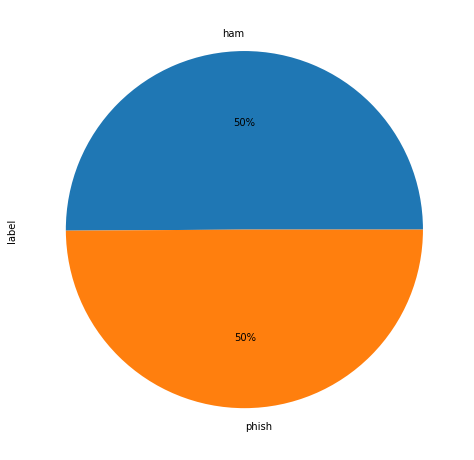

In [31]:
plt.rcParams["figure.figsize"] = [8,10] 
df.label.value_counts().plot(kind='pie', autopct='%1.0f%%')


<AxesSubplot:ylabel='malic'>

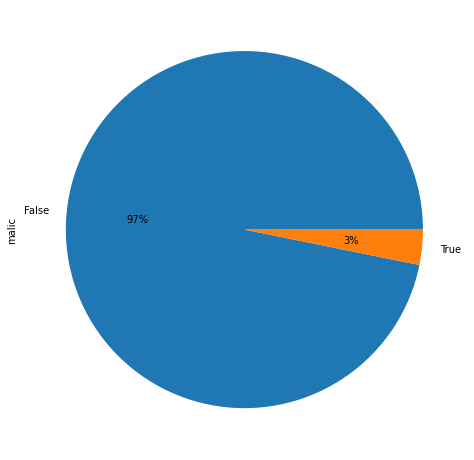

In [32]:
plt.rcParams["figure.figsize"] = [8,10] 
df.malic.value_counts().plot(kind='pie', autopct='%1.0f%%')

## Wordcloud

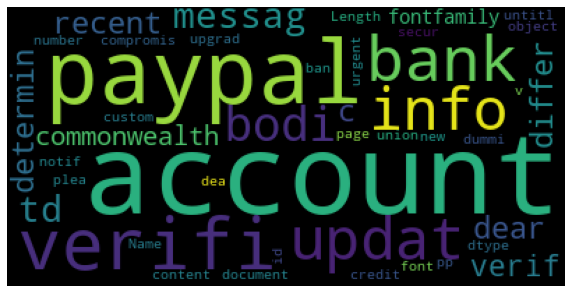

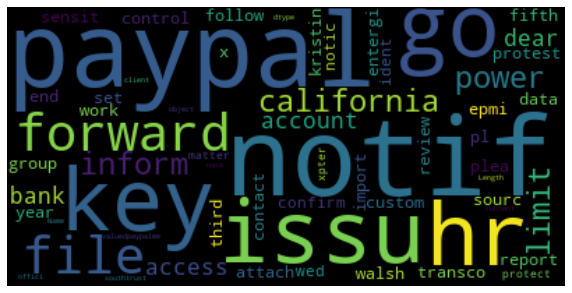

In [33]:
from wordcloud import WordCloud

df_ismalicious = df[df.malic.isin([True])]
text = df_ismalicious['content']
wordcloud = WordCloud().generate(str(text))
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

df_isnotmalicious = df[df.malic.isin([False])]
text = df_isnotmalicious['content']
wordcloud = WordCloud().generate(str(text))
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


## Frequency counts

In [34]:
#Frequent words
from collections import Counter
cnt = Counter()
for text in df["content"].values:
    for word in text.split():
        cnt[word] += 1
        
var = cnt.most_common(10)

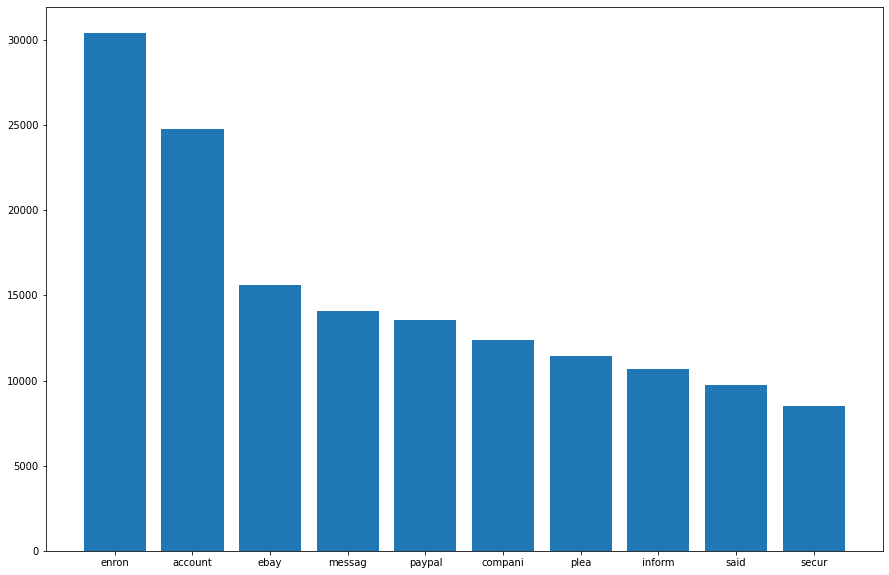

In [35]:
ind = []
fre = []
for item in var:
   ind.append(item[0])
   fre.append(item[1])
plt.figure(figsize=(15,10))
plt.bar(ind, fre)
plt.show()

## Heatmap

In [36]:
l = []
extract = []
i =0 
for key in sorted(cnt.keys()):    
    if cnt[key] >10 and cnt[key]<100 : 
        i+=1
        if i > 225 : break
        l.append(cnt[key])
        extract.append([key,cnt[key]])


In [37]:
len(l)

225

In [38]:
extract

[['\x1bb', 93],
 ['\x1bb\x1bb', 15],
 ['aa', 30],
 ['aactiv', 52],
 ['aaron', 15],
 ['ab', 76],
 ['abbey', 12],
 ['abbi', 13],
 ['abbott', 15],
 ['abbrevi', 12],
 ['abc', 33],
 ['abel', 14],
 ['abet', 11],
 ['abigail', 18],
 ['abn', 49],
 ['abruptli', 30],
 ['absent', 26],
 ['absolut', 88],
 ['absorb', 30],
 ['ac', 29],
 ['acc', 65],
 ['acceler', 70],
 ['accentur', 16],
 ['accid', 17],
 ['accommod', 60],
 ['accompani', 38],
 ['accordingli', 52],
 ['accounta', 73],
 ['accountalert', 15],
 ['accountand', 22],
 ['accountbr', 36],
 ['accountclick', 20],
 ['accountconfirmcopartneridpuseridsiteidpagetypeyour', 13],
 ['accountfeatur', 29],
 ['accountfrom', 24],
 ['accounthold', 21],
 ['accounti', 26],
 ['accountif', 47],
 ['accountin', 24],
 ['accountmak', 18],
 ['accountsbank', 25],
 ['accountï¿½', 12],
 ['accret', 18],
 ['accru', 32],
 ['accrual', 30],
 ['acctg', 11],
 ['accumul', 36],
 ['accuraci', 49],
 ['accus', 96],
 ['ace', 29],
 ['ackerman', 21],
 ['aconcagua', 11],
 ['acount', 19],
 

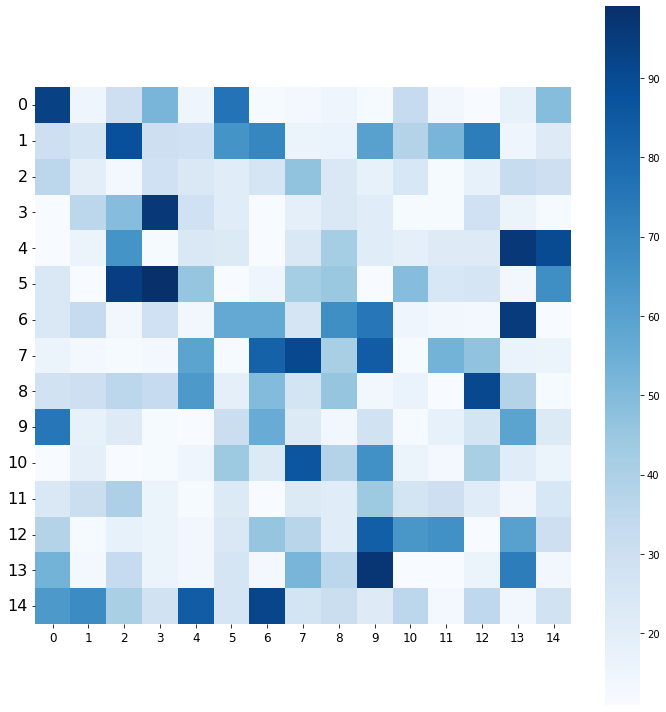

In [39]:
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

x_list = l[:225]
x = np.array((x_list))
x_res=x.reshape(15,15)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(x_res, square=True, ax=ax, cmap="Blues")

plt.yticks(rotation=0,fontsize=16);
plt.xticks(fontsize=12);
plt.tight_layout()

In [40]:
x_res

array([[93, 15, 30, 52, 15, 76, 12, 13, 15, 12, 33, 14, 11, 18, 49],
       [30, 26, 88, 30, 29, 65, 70, 16, 17, 60, 38, 52, 73, 15, 22],
       [36, 20, 13, 29, 24, 21, 26, 47, 24, 18, 25, 12, 18, 32, 30],
       [11, 36, 49, 96, 29, 21, 11, 19, 24, 21, 12, 12, 29, 16, 12],
       [11, 16, 65, 12, 24, 23, 11, 24, 42, 21, 19, 22, 22, 96, 90],
       [24, 11, 94, 99, 46, 11, 15, 42, 45, 11, 49, 25, 26, 14, 67],
       [24, 33, 14, 29, 14, 57, 57, 26, 67, 75, 15, 14, 13, 95, 11],
       [16, 13, 12, 13, 59, 12, 82, 91, 41, 84, 12, 53, 47, 17, 16],
       [28, 30, 36, 33, 63, 19, 50, 27, 46, 14, 17, 11, 91, 38, 12],
       [75, 18, 22, 12, 11, 31, 56, 23, 14, 28, 12, 18, 27, 59, 23],
       [11, 19, 11, 12, 15, 44, 23, 86, 38, 66, 16, 13, 41, 21, 16],
       [24, 31, 40, 16, 12, 23, 11, 23, 21, 44, 27, 30, 21, 14, 25],
       [38, 12, 18, 16, 14, 24, 46, 37, 21, 83, 64, 66, 11, 60, 30],
       [53, 13, 33, 16, 14, 26, 13, 52, 36, 97, 11, 11, 16, 73, 14],
       [63, 68, 41, 28, 84, 26, 92

In [41]:
len(df_emails[df_emails['malic'] == True])

317

In [42]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Madhu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Frequency distribution plot for phishing emails

In [49]:
#frequency distribution
stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')
phish_text_all = '\n'.join(df_phish.content).lower()
phish_tokens_all = tokenizer.tokenize(phish_text_all)
phish_tokens_all = [word for word in phish_tokens_all if word not in stop_words and word != 'font' and word != 'subject']

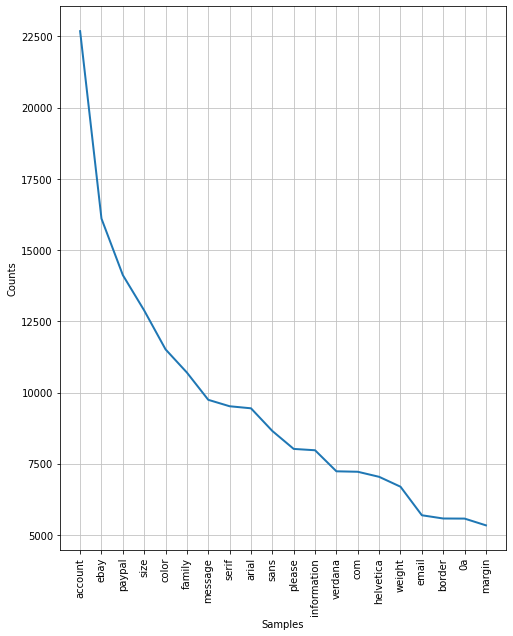

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [50]:
fd_phish = nltk.probability.FreqDist(phish_tokens_all)
fd_phish.plot(20)

# Train test split

In [52]:
df_emails_train, df_emails_test = train_test_split(df_emails, test_size=0.3, random_state=0)

# Measures Calculation

In [53]:
def malic_predict(df):
    if(df['malic'] == True):
        return 'phish'
    else:
        pass

In [54]:
kfold_accuracy = []

In [55]:
def Measures_report(df, model):

    # macro -
    # micro - 
    # weighted - 
    precision_scores_weighted = []
    precision_scores_micro = []
    precision_scores_macro = []
    
    precision_scores = []
    recall_scores = []
    
    f1_scores_macro = []
    f1_scores_micro = []
    f1_scores_weighted = []
    
    recall_scores_macro = []
    recall_scores_micro = []
    recall_scores_weighted = []
    
    
    accuracy_scores = []
    kf = KFold(n_splits = 5, shuffle = True, random_state = 1)
    fold = 0
    for train_ind, test_ind in kf.split(df):

        df_emails_train = df.iloc[train_ind]
        df_emails_test =  df.iloc[test_ind]
        # mapping content with appropriate label
        # improve accuracy
        model.fit(df_emails_train.content, df_emails_train.label)
        # predict labels of data values
        model_test_predicted = model.predict(df_emails_test.content)
        
        df_emails_test['predicted_label'] = df_emails_test.apply(malic_predict, axis = 1)
        netcraft_test_predicted = [x for x in df_emails_test['predicted_label']]
        test_predicted = []       
        # a  b 
        # p  p  p
        # p  h  p
        # h  h  h
        # h  p  p
        for a, b in zip(netcraft_test_predicted, model_test_predicted):
            if((a == 'phish') and (b != 'phish')):
                test_predicted.append(a)
            else:
                test_predicted.append(b)
        # print(test_predicted)      
        print('fold', fold)
        print (skmetrics.classification_report(df_emails_test.label, test_predicted))
        accuracy_scores.append(skmetrics.accuracy_score(df_emails_test.label, test_predicted))
        
        f1_scores_macro.append(skmetrics.f1_score(df_emails_test.label, test_predicted, average = 'macro'))
        f1_scores_micro.append(skmetrics.f1_score(df_emails_test.label, test_predicted, average = 'micro'))
        f1_scores_weighted.append(skmetrics.f1_score(df_emails_test.label, test_predicted, average = 'weighted'))
        
        precision_scores.append(skmetrics.precision_score(df_emails_test.label, test_predicted, pos_label = 'phish'))
        
        precision_scores_macro.append(skmetrics.precision_score(df_emails_test.label, test_predicted, average = 'macro'))
        precision_scores_micro.append(skmetrics.precision_score(df_emails_test.label, test_predicted, average = 'micro'))
        precision_scores_weighted.append(skmetrics.precision_score(df_emails_test.label, test_predicted, average = 'weighted'))
        
        recall_scores.append(skmetrics.recall_score(df_emails_test.label, test_predicted, pos_label = 'phish'))
        
        recall_scores_macro.append(skmetrics.recall_score(df_emails_test.label, test_predicted, average = 'macro'))
        recall_scores_micro.append(skmetrics.recall_score(df_emails_test.label, test_predicted, average = 'micro'))
        recall_scores_weighted.append(skmetrics.recall_score(df_emails_test.label, test_predicted, average = 'weighted'))
        
        
        fold += 1
    
    print('F1 Micro:', np.mean(f1_scores_micro))
    print('F1 Macro:', np.mean(f1_scores_macro))
    print('F1 Weighted:', np.mean(f1_scores_weighted))
    print()
    print('Precision Micro:', np.mean(precision_scores_micro))
    print('Precision Macro:', np.mean(precision_scores_macro))
    print('Preicision Weighted:', np.mean(precision_scores_weighted))
    print()
    print('Recall Micro:', np.mean(recall_scores_micro))
    print('Recall Macro:', np.mean(recall_scores_macro))
    print('Recall Weighted:', np.mean(recall_scores_weighted))
    print()
    print('avg accuracy:', round(np.mean(accuracy_scores), 2))
    kfold_accuracy.append([model,round(np.mean(accuracy_scores), 2)])
    print('avg phish precision:', round(np.mean(precision_scores), 2))
    print('avg phish recall:', round(np.mean(recall_scores), 2))
    print()
   

In [56]:
global_accuracy = []

# Random Forest

In [57]:
rf_pipeline = skpipe.Pipeline(
    steps = [('vect', skft.CountVectorizer(max_df=0.7)),
     ('tfidf', skft.TfidfTransformer()),
     ('clf', RandomForestClassifier(max_depth=5, n_estimators=100))])


train_predicted = rf_pipeline.fit(df_emails_train.content, df_emails_train.label)

In [58]:
test_predicted = rf_pipeline.predict(df_emails_test.content)

In [59]:
print (skmetrics.classification_report(df_emails_test.label, test_predicted))

              precision    recall  f1-score   support

         ham       0.85      1.00      0.92      1485
       phish       1.00      0.82      0.90      1510

    accuracy                           0.91      2995
   macro avg       0.92      0.91      0.91      2995
weighted avg       0.92      0.91      0.91      2995



In [60]:
accuracy =  skmetrics.accuracy_score(df_emails_test.label, test_predicted)
print ('Accuracy:',accuracy)
global_accuracy.append(["Random Forest",accuracy])

Accuracy: 0.9091819699499165


In [61]:
kfold = KFold(n_splits=5, random_state=0, shuffle = True)

In [62]:
# predicted values
rf_scores = cross_val_predict(rf_pipeline, df_emails.content, df_emails.label, cv=kfold)

In [63]:
rf_scores

array(['ham', 'ham', 'ham', ..., 'phish', 'phish', 'ham'], dtype=object)

In [64]:
df_emails.head()

,label,title,content,malic
0,ham,0001.2001-02-07.kitchen.ham.txt,key hr issu go forward year end review report ...,False
1,ham,0003.2001-02-08.kitchen.ham.txt,key hr issu go forward control set work group ...,False
2,ham,0005.2001-02-08.kitchen.ham.txt,epmi file protest entergi transco attach file ...,False
3,ham,0006.2001-02-08.kitchen.ham.txt,california power plea contact kristin walsh x ...,False
4,ham,0007.2001-02-09.kitchen.ham.txt,california power follow inform sensit sourc pl...,False


In [65]:
print(skmetrics.classification_report(df_emails.label, rf_scores))

              precision    recall  f1-score   support

         ham       0.86      1.00      0.92      5000
       phish       1.00      0.83      0.91      4981

    accuracy                           0.92      9981
   macro avg       0.93      0.92      0.92      9981
weighted avg       0.93      0.92      0.92      9981



In [66]:
Measures_report(df_emails, rf_pipeline)

fold 0
              precision    recall  f1-score   support

         ham       0.85      1.00      0.92       997
       phish       1.00      0.82      0.90      1000

    accuracy                           0.91      1997
   macro avg       0.92      0.91      0.91      1997
weighted avg       0.92      0.91      0.91      1997

fold 1
              precision    recall  f1-score   support

         ham       0.86      1.00      0.92      1010
       phish       1.00      0.84      0.91       986

    accuracy                           0.92      1996
   macro avg       0.93      0.92      0.92      1996
weighted avg       0.93      0.92      0.92      1996

fold 2
              precision    recall  f1-score   support

         ham       0.85      1.00      0.92       993
       phish       1.00      0.83      0.91      1003

    accuracy                           0.91      1996
   macro avg       0.93      0.91      0.91      1996
weighted avg       0.93      0.91      0.91      1996

# Decision Tree


In [67]:
dt_pipeline = skpipe.Pipeline(
    steps = [('vect', skft.CountVectorizer(max_df=0.7)),
     ('tfidf', skft.TfidfTransformer()),
     ('clf', DecisionTreeClassifier(max_depth=5, random_state=68))])


dt_pipeline.fit(df_emails_train.content, df_emails_train.label)

Pipeline(steps=[('vect', CountVectorizer(max_df=0.7)),
                ('tfidf', TfidfTransformer()),
                ('clf', DecisionTreeClassifier(max_depth=5, random_state=68))])

In [68]:
clf = dt_pipeline[2]

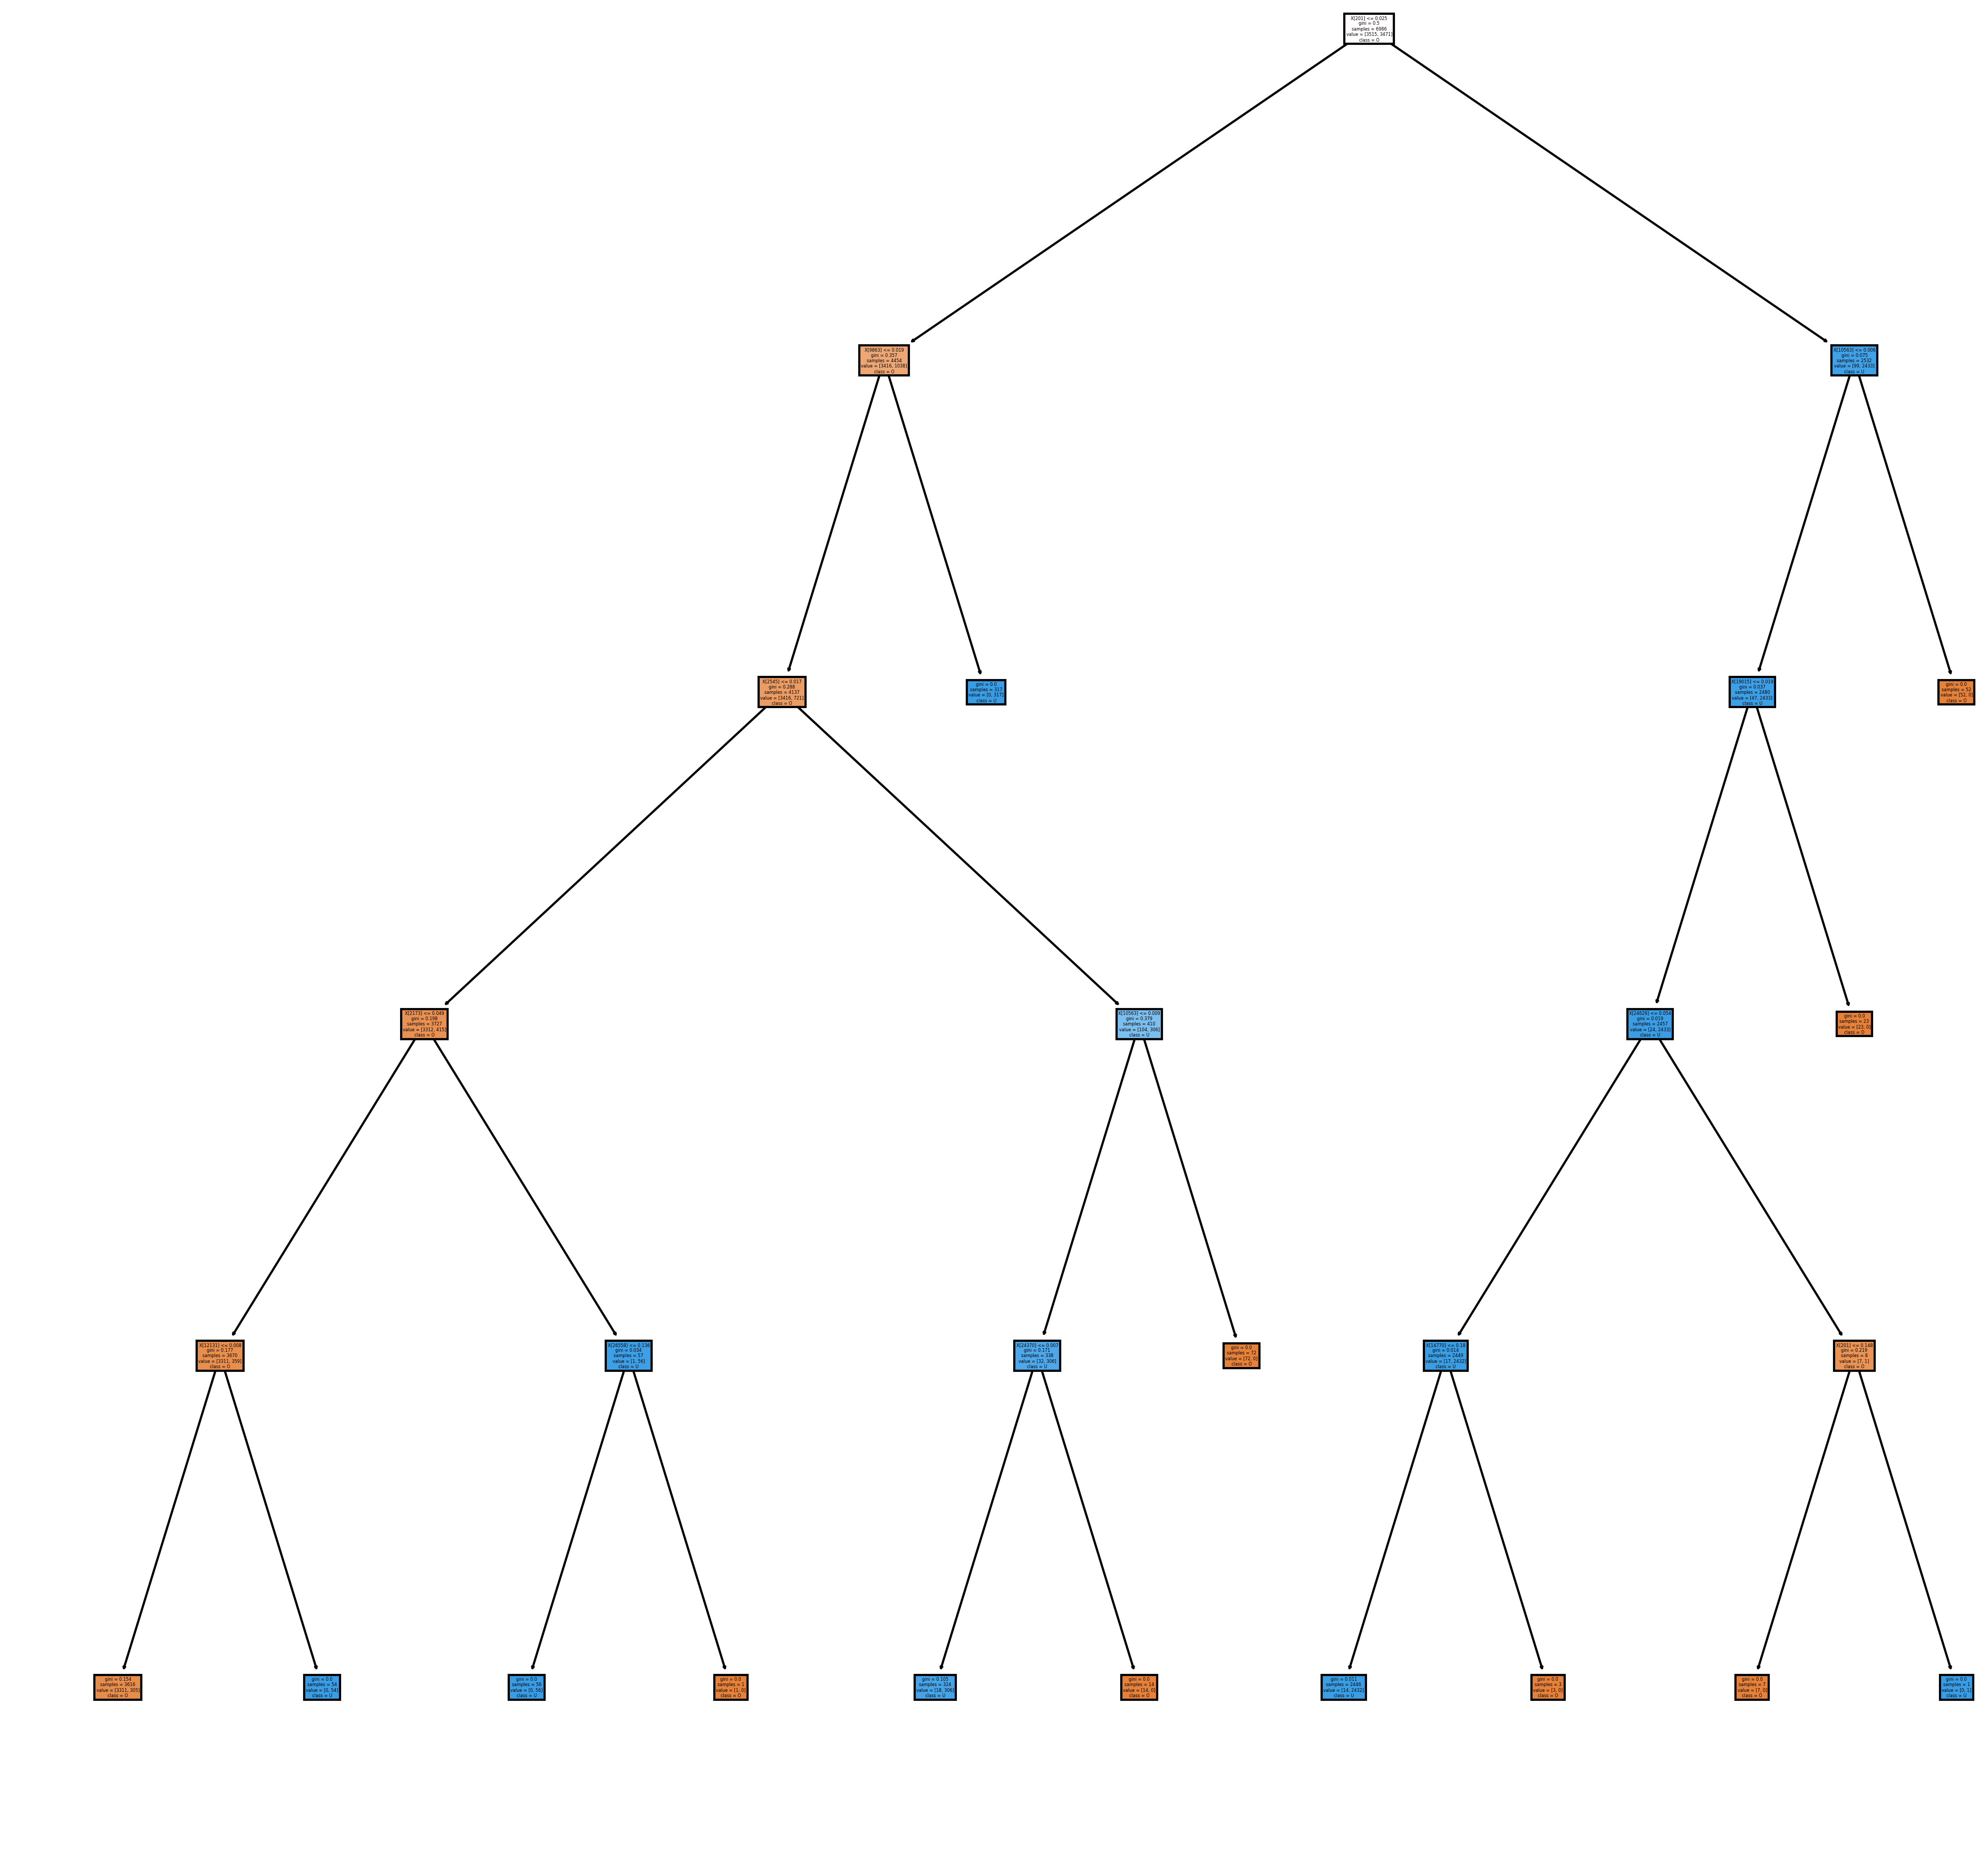

In [69]:
from sklearn import tree
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(clf,
               class_names='OUTPUT_LABEL',
               filled = True);
# fig.savefig('imagename.png')

In [70]:
test_predicted = dt_pipeline.predict(df_emails_test.content)

In [71]:
print (skmetrics.classification_report(df_emails_test.label, test_predicted))

              precision    recall  f1-score   support

         ham       0.91      0.99      0.95      1485
       phish       0.98      0.90      0.94      1510

    accuracy                           0.94      2995
   macro avg       0.95      0.94      0.94      2995
weighted avg       0.95      0.94      0.94      2995



In [72]:
accuracy =  skmetrics.accuracy_score(df_emails_test.label, test_predicted)
print ('Accuracy:',accuracy)
global_accuracy.append(["Decision Tree",np.mean(accuracy)])

Accuracy: 0.9445742904841402


In [73]:
kfold = KFold(n_splits=5, random_state=0, shuffle = True)


In [74]:
dt_scores = cross_val_predict(dt_pipeline, df_emails.content, df_emails.label, cv=kfold)


In [75]:
print(skmetrics.classification_report(df_emails.label, dt_scores))


              precision    recall  f1-score   support

         ham       0.92      0.99      0.95      5000
       phish       0.99      0.91      0.95      4981

    accuracy                           0.95      9981
   macro avg       0.95      0.95      0.95      9981
weighted avg       0.95      0.95      0.95      9981



In [76]:
Measures_report(df_emails, dt_pipeline)

fold 0
              precision    recall  f1-score   support

         ham       0.91      0.99      0.95       997
       phish       0.99      0.90      0.94      1000

    accuracy                           0.95      1997
   macro avg       0.95      0.95      0.95      1997
weighted avg       0.95      0.95      0.95      1997

fold 1
              precision    recall  f1-score   support

         ham       0.92      0.99      0.95      1010
       phish       0.99      0.91      0.95       986

    accuracy                           0.95      1996
   macro avg       0.96      0.95      0.95      1996
weighted avg       0.96      0.95      0.95      1996

fold 2
              precision    recall  f1-score   support

         ham       0.91      0.98      0.95       993
       phish       0.98      0.91      0.94      1003

    accuracy                           0.94      1996
   macro avg       0.95      0.94      0.94      1996
weighted avg       0.95      0.94      0.94      1996

# Multinomial Naive Bayes

why - for independent input data (spam ham)

In [77]:
pipeline = skpipe.Pipeline(
    steps = [('vect', skft.CountVectorizer(max_df=0.7)),
     ('tfidf', skft.TfidfTransformer()),
     ('clf', sknb.MultinomialNB())])


In [78]:
pipeline.fit(df_emails_train.content, df_emails_train.label)

Pipeline(steps=[('vect', CountVectorizer(max_df=0.7)),
                ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])

In [79]:
nb_test_predicted = pipeline.predict(df_emails_test.content)

In [80]:
df_emails_test.head()

,label,title,content,malic
600,phish,261_False.txt,paypal account secur measur td width dear payp...,False
1840,phish,625_False.txt,custom notif detail confirm messid dear bank w...,False
356,phish,1328_False.txt,notif limit account access dear chase valu cus...,False
1861,ham,2568.2001-09-18.kitchen.ham.txt,gtv weekli project statu report plea find proj...,False
1509,ham,2080.2001-08-21.kitchen.ham.txt,thank offsit thank offsit great spend time peo...,False


In [81]:
df_emails_test['predicted_label'] = df_emails_test.apply(malic_predict, axis = 1)

In [82]:
df_emails_test.head()

,label,title,content,malic,predicted_label
600,phish,261_False.txt,paypal account secur measur td width dear payp...,False,None
1840,phish,625_False.txt,custom notif detail confirm messid dear bank w...,False,None
356,phish,1328_False.txt,notif limit account access dear chase valu cus...,False,None
1861,ham,2568.2001-09-18.kitchen.ham.txt,gtv weekli project statu report plea find proj...,False,None
1509,ham,2080.2001-08-21.kitchen.ham.txt,thank offsit thank offsit great spend time peo...,False,None


In [83]:
netcraft_test_predicted = [x for x in df_emails_test['predicted_label']]

In [84]:
test_predicted = []
for a, b in zip(netcraft_test_predicted, nb_test_predicted):
    #print(a, b)
    if((a == 'phish') and (b != 'phish')):
        test_predicted.append(a)
    else:
        test_predicted.append(b)

In [85]:
df_emails_test['predicted_label'] = test_predicted

In [86]:
df_emails_test.head()

,label,title,content,malic,predicted_label
600,phish,261_False.txt,paypal account secur measur td width dear payp...,False,phish
1840,phish,625_False.txt,custom notif detail confirm messid dear bank w...,False,phish
356,phish,1328_False.txt,notif limit account access dear chase valu cus...,False,phish
1861,ham,2568.2001-09-18.kitchen.ham.txt,gtv weekli project statu report plea find proj...,False,ham
1509,ham,2080.2001-08-21.kitchen.ham.txt,thank offsit thank offsit great spend time peo...,False,ham


In [87]:
accuracy =  skmetrics.accuracy_score(df_emails_test.label, test_predicted)
print ('Accuracy:',accuracy)
global_accuracy.append(["Multinomial NB",np.mean(accuracy)])

Accuracy: 0.9656093489148581


In [88]:
print (skmetrics.classification_report(df_emails_test.label, test_predicted))

              precision    recall  f1-score   support

         ham       0.94      1.00      0.97      1485
       phish       1.00      0.93      0.96      1510

    accuracy                           0.97      2995
   macro avg       0.97      0.97      0.97      2995
weighted avg       0.97      0.97      0.97      2995



In [89]:
print(kfold)

KFold(n_splits=5, random_state=0, shuffle=True)


In [90]:
nb_scores = cross_val_predict(pipeline, df_emails.content, df_emails.label, cv=kfold)

In [91]:
print(skmetrics.classification_report(df_emails.label, nb_scores))

              precision    recall  f1-score   support

         ham       0.95      1.00      0.97      5000
       phish       1.00      0.94      0.97      4981

    accuracy                           0.97      9981
   macro avg       0.97      0.97      0.97      9981
weighted avg       0.97      0.97      0.97      9981



In [92]:
Measures_report(df_emails, pipeline)

fold 0
              precision    recall  f1-score   support

         ham       0.94      1.00      0.97       997
       phish       1.00      0.93      0.96      1000

    accuracy                           0.96      1997
   macro avg       0.97      0.96      0.96      1997
weighted avg       0.97      0.96      0.96      1997

fold 1
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98      1010
       phish       1.00      0.96      0.98       986

    accuracy                           0.98      1996
   macro avg       0.98      0.98      0.98      1996
weighted avg       0.98      0.98      0.98      1996

fold 2
              precision    recall  f1-score   support

         ham       0.95      1.00      0.97       993
       phish       1.00      0.95      0.97      1003

    accuracy                           0.97      1996
   macro avg       0.97      0.97      0.97      1996
weighted avg       0.97      0.97      0.97      1996

# Support Vector Machine

In [93]:
svm_pipeline = skpipe.Pipeline(
    steps = [('vect', skft.CountVectorizer(max_df=0.7, ngram_range = (1,1))),
     ('tfidf', skft.TfidfTransformer(use_idf = True)),
     ('clf', SGDClassifier())]
)

svm_pipeline.fit(df_emails_train.content, df_emails_train.label)

Pipeline(steps=[('vect', CountVectorizer(max_df=0.7)),
                ('tfidf', TfidfTransformer()), ('clf', SGDClassifier())])

In [94]:
test_predicted = svm_pipeline.predict(df_emails_test.content)

In [95]:
print(skmetrics.classification_report(df_emails_test.label, test_predicted))

              precision    recall  f1-score   support

         ham       0.99      1.00      1.00      1485
       phish       1.00      0.99      1.00      1510

    accuracy                           1.00      2995
   macro avg       1.00      1.00      1.00      2995
weighted avg       1.00      1.00      1.00      2995



In [96]:
accuracy =  skmetrics.accuracy_score(df_emails_test.label, test_predicted)
print ('Accuracy:',accuracy)
global_accuracy.append(["SVM",accuracy])

Accuracy: 0.9963272120200334


In [97]:
kfold = KFold(n_splits=5, random_state=0, shuffle = True)

In [98]:
svm_scores = cross_val_predict(svm_pipeline, df_emails.content, df_emails.label, cv=kfold)

In [99]:
print(skmetrics.classification_report(df_emails.label, svm_scores))

              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      5000
       phish       1.00      1.00      1.00      4981

    accuracy                           1.00      9981
   macro avg       1.00      1.00      1.00      9981
weighted avg       1.00      1.00      1.00      9981



In [100]:
Measures_report(df_emails, svm_pipeline)

fold 0
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       997
       phish       0.99      0.99      0.99      1000

    accuracy                           0.99      1997
   macro avg       0.99      0.99      0.99      1997
weighted avg       0.99      0.99      0.99      1997

fold 1
              precision    recall  f1-score   support

         ham       0.99      1.00      1.00      1010
       phish       1.00      0.99      0.99       986

    accuracy                           0.99      1996
   macro avg       1.00      0.99      0.99      1996
weighted avg       0.99      0.99      0.99      1996

fold 2
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00       993
       phish       1.00      1.00      1.00      1003

    accuracy                           1.00      1996
   macro avg       1.00      1.00      1.00      1996
weighted avg       1.00      1.00      1.00      1996

# K-nearest Neigbours

In [101]:
from sklearn.neighbors import KNeighborsClassifier
knn_pipeline = skpipe.Pipeline(
    steps = [('vect', skft.CountVectorizer(max_df=0.7)),
     ('tfidf', skft.TfidfTransformer()),
     ('clf', KNeighborsClassifier(n_neighbors = 3))])


knn_pipeline.fit(df_emails_train.content, df_emails_train.label)

Pipeline(steps=[('vect', CountVectorizer(max_df=0.7)),
                ('tfidf', TfidfTransformer()),
                ('clf', KNeighborsClassifier(n_neighbors=3))])

In [102]:
test_predicted = knn_pipeline.predict(df_emails_test.content)

In [103]:
print (skmetrics.classification_report(df_emails_test.label, test_predicted))


              precision    recall  f1-score   support

         ham       1.00      0.34      0.51      1485
       phish       0.61      1.00      0.76      1510

    accuracy                           0.67      2995
   macro avg       0.80      0.67      0.63      2995
weighted avg       0.80      0.67      0.63      2995



In [104]:
accuracy =  skmetrics.accuracy_score(df_emails_test.label, test_predicted)
print ('Accuracy:',accuracy)
global_accuracy.append(["KNN",accuracy])

Accuracy: 0.6734557595993322


In [105]:
kfold = KFold(n_splits=5, random_state=0, shuffle = True)


In [106]:
knn_scores = cross_val_predict(knn_pipeline, df_emails.content, df_emails.label, cv=kfold)


In [107]:
print(skmetrics.classification_report(df_emails.label, knn_scores))


              precision    recall  f1-score   support

         ham       1.00      0.35      0.52      5000
       phish       0.61      1.00      0.75      4981

    accuracy                           0.67      9981
   macro avg       0.80      0.68      0.64      9981
weighted avg       0.80      0.67      0.64      9981



In [108]:
Measures_report(df_emails, knn_pipeline)

fold 0
              precision    recall  f1-score   support

         ham       1.00      0.33      0.50       997
       phish       0.60      1.00      0.75      1000

    accuracy                           0.67      1997
   macro avg       0.80      0.67      0.62      1997
weighted avg       0.80      0.67      0.62      1997

fold 1
              precision    recall  f1-score   support

         ham       1.00      0.35      0.52      1010
       phish       0.60      1.00      0.75       986

    accuracy                           0.67      1996
   macro avg       0.80      0.67      0.63      1996
weighted avg       0.80      0.67      0.63      1996

fold 2
              precision    recall  f1-score   support

         ham       1.00      0.37      0.54       993
       phish       0.61      1.00      0.76      1003

    accuracy                           0.68      1996
   macro avg       0.81      0.68      0.65      1996
weighted avg       0.81      0.68      0.65      1996

# CONCLUSION

In [109]:
k = []
for i in range(len(kfold_accuracy)):
    k.append([str(kfold_accuracy[i][0]['clf']).split("(")[0],kfold_accuracy[i][1]])



In [110]:
global_scores = [row[1] for row in global_accuracy]
global_kscores = [row[1] for row in k]

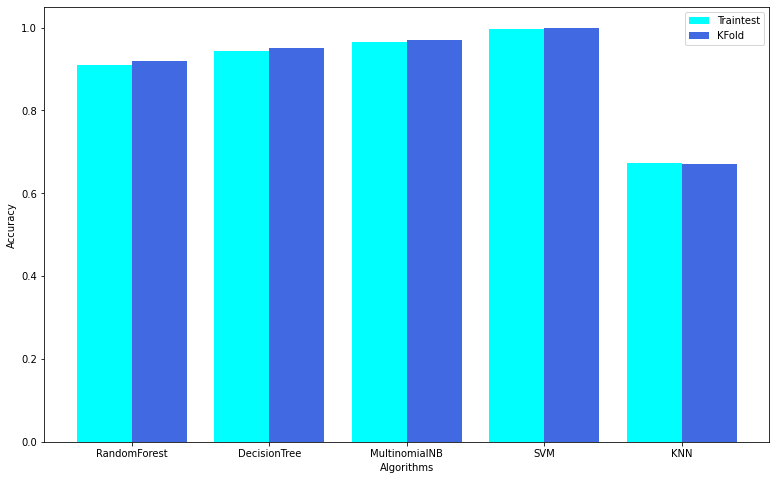

In [111]:
# importing package
import matplotlib.pyplot as plt
import numpy as np
  
# create data
x = np.arange(5)
y1 = global_scores
y2 = global_kscores

width = 0.4
plt.figure(figsize=(13, 8))
# plot data in grouped manner of bar type
plt.bar(x-0.2, y1, width, color='cyan')
plt.bar(x+0.2, y2, width, color='royalblue')
plt.xticks(x, ['RandomForest','DecisionTree','MultinomialNB','SVM','KNN'])
plt.xlabel("Algorithms")
plt.ylabel("Accuracy")
plt.legend(["Traintest", "KFold"])
# plt.figure(figsize=(1,10))
plt.show()